# Comparisons In A Given Loss Landscape

In [1]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from minima_volume.analysis_funcs import (  grab_folder_names,
                                            load_base_train_size,
                                            list_additional_data,
                                            load_param_num,
                                            multiple_minima_fixed_landscape,
                                            fixed_landscape_minima_labels,
                                            plot_fixed_landscape_minima_pair,
                                            model_volume_across_targets,
                                            append_cutoff_points,
                                            varying_landscape_minima_labels,
                                            plot_minima_volume_vs_data_level,    
                                            save_results_dict_npz,
)

problem_name = "Modulo Arithmetic"

loss_value = 0.01  # Loss value to analyze
data_level_log = False #Is the data log distributed?
base_output_dir = "analysis"  # Root folder to save all plots
os.makedirs(base_output_dir, exist_ok=True)

# Data for the loss landscape levels
experiment_folders, data_modifications = grab_folder_names()

base_train_size = load_base_train_size(experiment_folders[0])
model_data_sizes = list_additional_data(experiment_folders[0])
num_params = load_param_num(experiment_folders[0], data_modifications[0], loss_value = loss_value)

base_shift = 0
#if data_modifications[0].startswith("data_"):
#    base_shift = base_train_size  # Shift to reflect true dataset size

print("Experiment folders: ", experiment_folders)
print("Different data levels where loss landscapes were computed:", data_modifications)
print("The base train size is: ", base_train_size)
print("Data levels where models were trained: ", model_data_sizes)
print("The number of model parameters is ", num_params)

First entry: Model_0, base_train_size = 2822
Experiment folders:  ['model_0_data_10', 'model_1_data_11', 'model_2_data_12', 'model_3_data_13', 'model_4_data_14']
Different data levels where loss landscapes were computed: ['data_0']
The base train size is:  2822
Data levels where models were trained:  [0]
The number of model parameters is  73097


## Plotting Different Model Volumes In A Landscape

In [2]:
# Needed for fixed colors for background plots
import matplotlib as mpl

#cmap = mpl.colormaps.get_cmap("winter")  # blue → green
#background_colors = [cmap(i) for i in np.linspace(0, 1, 10)]

#natural_label = "Minima (On Base Dataset)"
if data_modifications[0].startswith("data_"):
    other_label = "500 Epochs"
else:
    other_label = "Minima (Poisoned Datasets)"


Processing data modification folder: data_0
Saved data to analysis\data_0\minima_data.npz


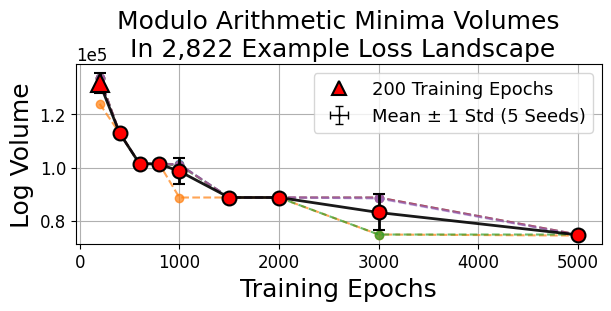

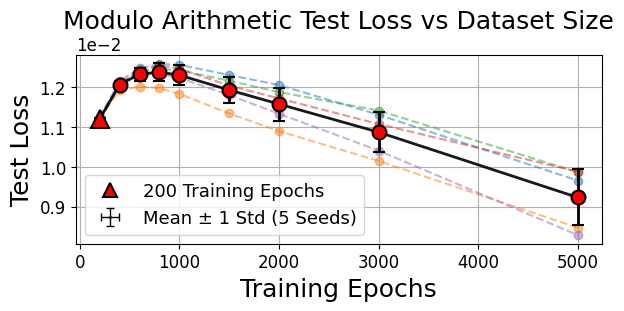

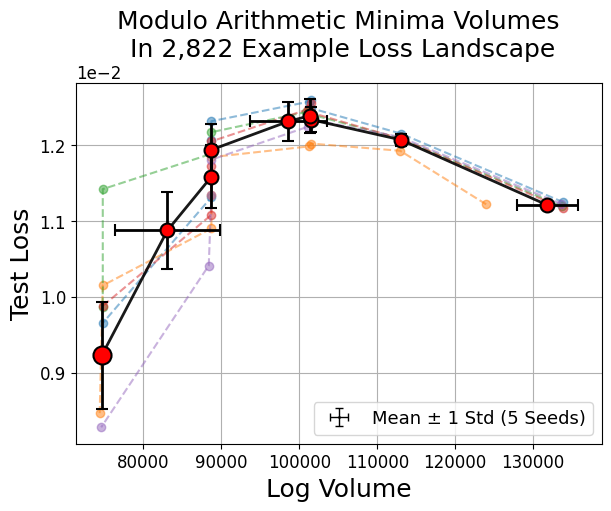

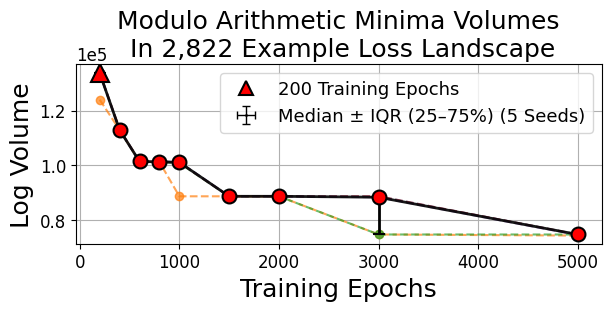

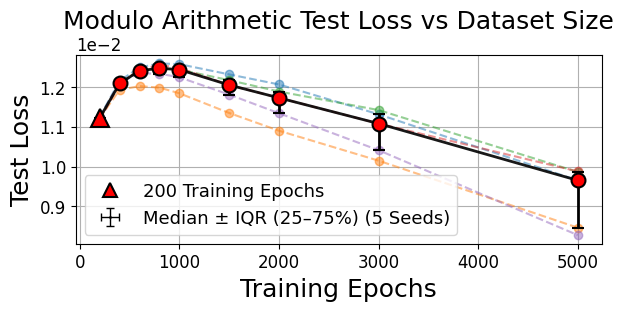

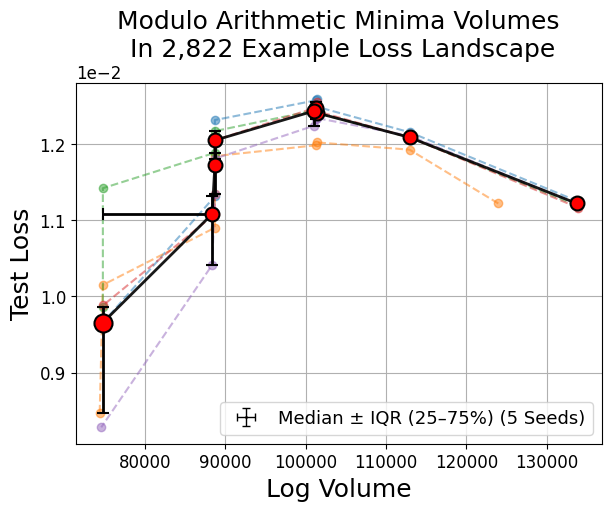

In [3]:
for data_modification in data_modifications:
    print(f"\nProcessing data modification folder: {data_modification}")

    # Create output folder for this data_modification
    save_dir = os.path.join(base_output_dir, data_modification)
    os.makedirs(save_dir, exist_ok=True)

    # Get axis labels and titles
    labels = fixed_landscape_minima_labels(data_modification, base_train_size)

    # Extract minima landscapes
    all_mdl, all_log_rn, all_test_loss = multiple_minima_fixed_landscape(
        experiment_folders, data_modification, loss_value #mdl is modification data level
    )
    number_of_minima = len(all_mdl[0]) # Not used currently

    all_mdl = np.array(all_mdl)
    all_log_rn = np.array(all_log_rn)
    all_test_loss = np.array(all_test_loss)
    
    # Print types and shapes
    #for name, var in [("all_mdl", all_mdl), ("all_log_rn", all_log_rn), ("all_test_loss", all_test_loss)]:
    #    print(f"{name}: type={type(var)}, shape={var.shape}")

    # Save the data using np.savez_compressed
    save_dict = {
        'all_mdl': all_mdl,
        'all_log_rn': all_log_rn,
        'all_test_loss': all_test_loss,
        'data_modification': np.array([data_modification], dtype=object),
        'base_train_size': np.array([base_train_size]),
        'base_shift': np.array([base_shift]),
        'labels': labels
    }
    
    output_path = save_dir
    filename = 'minima_data.npz'
    np.savez_compressed(os.path.join(output_path, filename), **save_dict)
    
    print(f"Saved data to {os.path.join(output_path, filename)}")
    
    # Central tendency runs: mean and median
    for ct, suffix in [("mean", "_avg"), ("median", "_median")]:
        for ranking in [False, True]:
            out_dir = save_dir if not ranking else os.path.join(save_dir, "ranks") #handles ranking
            os.makedirs(out_dir, exist_ok=True)

            # --- Data-level plots: loop through shaded + errorbar ---
            #for avg_style in ["shaded", "errorbar"]:
            #    style_suffix = "_shaded" if avg_style == "shaded" else "_errbar"
            style_suffix = "_errbar"
            avg_style = "errorbar"

            # --- Data level vs Log Volume ---
            plot_fixed_landscape_minima_pair(
                all_mdl, all_log_rn,
                xlabel="Training Epochs", ylabel="Log Volume",
                title=f"{problem_name} Minima Volumes\n In {base_train_size:,} Example Loss Landscape",
                #labels["title_volume"],
                log_scale=data_level_log,
                ranking=ranking,
                alpha=0.7,
                output_dir=out_dir,
                filename="data_level_vs_log_volume" + suffix + style_suffix,
                show_plot=not ranking,
                plot_average=True,
                average_style=avg_style,
                central_tendency=ct,
                plot_x_error=(avg_style == "errorbar"),
                xlabel_size=18, ylabel_size=18, title_size=18, legend_size = 13, tick_size = 12,
                base_shift=base_shift,
                background_colors=None,#background_colors,     
                natural_minima_loc = 'first',
                natural_label=f"200 Training Epochs",
                other_label=None,               
                natural_marker="^",            
                other_marker="o",      
                figsize=(6, 3),
            )

            # --- Data level vs Test Loss ---
            plot_fixed_landscape_minima_pair(
                all_mdl, all_test_loss,
                xlabel="Training Epochs", ylabel="Test Loss",
                title=f"{problem_name} Test Loss vs Dataset Size",#labels["title_volume"],
                log_scale=False,
                ranking=ranking,
                alpha=0.5,
                output_dir=out_dir,
                filename="data_level_vs_test_loss" + suffix + style_suffix,
                show_plot=not ranking,
                plot_average=True,
                average_style=avg_style,
                central_tendency=ct,
                plot_x_error=(avg_style == "errorbar"),
                xlabel_size=18, ylabel_size=18, title_size=18, legend_size = 13, tick_size = 12,
                base_shift=base_shift,
                background_colors=None,#background_colors,     
                natural_minima_loc = 'first',
                natural_label=f"200 Training Epochs",
                other_label=None,      
                natural_marker="^",            
                other_marker="o",  
                figsize=(6, 3),
            )

            # --- Log Volume vs Test Loss ---
            # Only error bar version (no shaded version)
            plot_fixed_landscape_minima_pair(
                all_log_rn, all_test_loss,
                xlabel="Log Volume", ylabel="Test Loss",
                title=f"{problem_name} Minima Volumes\n In {base_train_size + int(data_modification.split("_")[1]):,} Example Loss Landscape",
                #labels["title_volume"],
                log_scale=False,
                ranking=ranking,
                alpha=0.5,
                output_dir=out_dir,
                filename="log_volume_vs_test_loss" + suffix + "_errbar",
                show_plot=not ranking,
                plot_average=True,
                average_style="errorbar",
                central_tendency=ct,
                plot_x_error=True,  # allow x-error bars
                xlabel_size=18, ylabel_size=18, title_size=18, legend_size = 13, tick_size = 12,
                background_colors=None,#background_colors,              
                #natural_minima_loc = 'last',
                #natural_label=f"Minima (Trained On {base_train_size + int(data_modification.split("_")[1]):,} Examples)", 
                #other_label=other_label,               
                #natural_marker="^",            
                other_marker="o",               
            )

# Aggregrate Test Accuracy

Test accuracy vs dataset size across all plots.

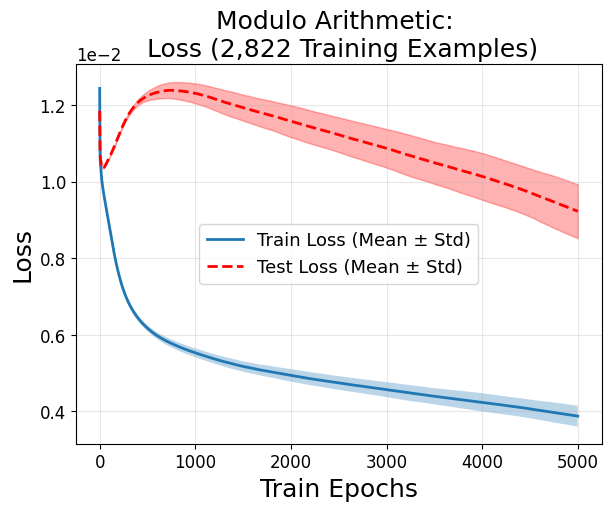

✅ Averaged Loss curves saved to analysis\loss_mean_std.png


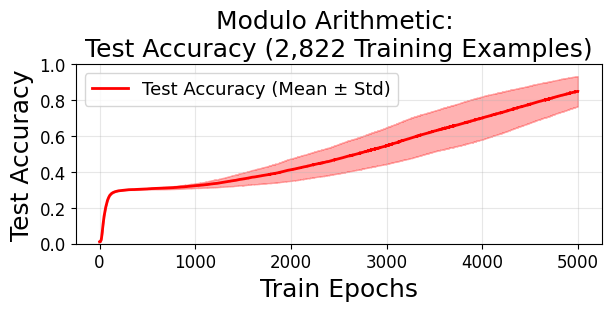

✅ Averaged Accuracy curves saved to analysis\accuracy_mean_std.png


In [6]:
missing_folders = [
    folder for folder in experiment_folders
    if not os.path.exists(os.path.join(folder, "losses.npz"))
]

if missing_folders:
    print(f"⚠️ Skipping aggregation — missing files in: {missing_folders}")
else:
    # Will store loss curves for plotting (only one model per experiment)
    all_train_losses = []
    all_test_losses = []
    all_accuracies = []

    for folder in experiment_folders:
        # ---- Load train/test loss curves ----
        loss_path = os.path.join(folder, "losses.npz")
        loss_data = np.load(loss_path)
        all_train_losses.append(loss_data["train_loss"])
        all_test_losses.append(loss_data["test_loss"])
        all_accuracies.append(loss_data["test_acc"])

    # Convert lists to numpy arrays for easy averaging
    # Shape: (num_experiments, num_epochs)
    train_arr = np.array([np.array(x) for x in all_train_losses], dtype=object)
    test_arr  = np.array([np.array(x) for x in all_test_losses], dtype=object)
    acc_arr   = np.array([np.array(x) for x in all_accuracies], dtype=object)
    
    # If different lengths exist, truncate to minimum length
    min_len = min([len(x) for x in train_arr])
    train_arr = np.array([x[:min_len] for x in train_arr], dtype=float)
    test_arr  = np.array([x[:min_len] for x in test_arr], dtype=float)
    acc_arr   = np.array([x[:min_len] for x in acc_arr], dtype=float)
    
    epochs = np.arange(min_len)
    
    # ==============================
    # Plot 1: Mean ± Std for Loss
    # ==============================
    fig = plt.figure(figsize=(6, 5), constrained_layout=True)
    ax = plt.gca()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,2))    
    ax.yaxis.get_offset_text().set_fontsize(12)  # Change 20 to your desired size
    
    # Train loss
    train_mean = train_arr.mean(axis=0)
    train_std  = train_arr.std(axis=0)
    plt.plot(epochs, train_mean, lw=2, label="Train Loss (Mean ± Std)")
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.3)
    
    # Test loss
    test_mean = test_arr.mean(axis=0)
    test_std  = test_arr.std(axis=0)
    plt.plot(epochs, test_mean, lw=2, label="Test Loss (Mean ± Std)", linestyle='--', color="r")
    plt.fill_between(epochs, test_mean - test_std, test_mean + test_std, alpha=0.3, color="r")
    
    plt.xlabel("Train Epochs", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.title(f"Modulo Arithmetic: \n Loss ({base_train_size:,} Training Examples)", fontsize=18)
    plt.legend(fontsize = 13)
    plt.grid(True, alpha=0.3)
    #plt.tight_layout()

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    loss_plot_path = os.path.join(base_output_dir, "loss_mean_std.png")
    plt.savefig(loss_plot_path, bbox_inches="tight")
    plt.show()
    print(f"✅ Averaged Loss curves saved to {loss_plot_path}")
    
    # ==============================
    # Plot 2: Mean ± Std for Accuracy
    # ==============================
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    ax = plt.gca()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,2))    
    
    acc_mean = acc_arr.mean(axis=0)
    acc_std  = acc_arr.std(axis=0)
    
    plt.plot(epochs, acc_mean, lw=2, label="Test Accuracy (Mean ± Std)", color="r")
    plt.fill_between(epochs, acc_mean - acc_std, acc_mean + acc_std, alpha=0.3, color="r")
    
    plt.xlabel("Train Epochs", fontsize=18)
    plt.ylabel("Test Accuracy", fontsize=18)
    plt.title(f"Modulo Arithmetic: \nTest Accuracy ({base_train_size:,} Training Examples)", fontsize=18)
    plt.legend(fontsize = 13)
    plt.grid(True, alpha=0.3)

    plt.ylim((0,1))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    acc_plot_path = os.path.join(base_output_dir, "accuracy_mean_std.png")
    plt.savefig(acc_plot_path, bbox_inches="tight")
    plt.show()
    print(f"✅ Averaged Accuracy curves saved to {acc_plot_path}")

                #xlabel_size=18, ylabel_size=18, title_size=18, legend_size = 13, tick_size = 12,
